# Analysis of QCFFPI results

This notebook contains:

* a comparison of the MOs of 4nm $\times$ 4nm MAC structures (obtained via kinetic Monte Carlo) with their Boys-Foster images
* comparison of ARPACK and QCFFPI MOs of 10nm $\times$ 10nm MAC 

# Boys-Foster on 4nm $\times$ 4nm MAC (QCFFPI MOs)

In [2]:
%matplotlib widget

from os import path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from qcnico.qcffpi_io import read_energies, read_MO_file
from qcnico.qcplots import plot_MO

def gen_mos(Mdir,lbls,filename_template='MOs_kMC_MAC_4x4', yield_pos=False):
    for nn in lbls:
        if yield_pos:
            yield read_MO_file(Mdir+f'{filename_template}-{nn}.dat')
        else: # yield MO only
            yield read_MO_file(Mdir+f'{filename_template}-{nn}.dat')[1]

def gen_energies(edir,lbls,filename_template='orb_energy_kMC_MAC_4x4'):
    for nn in lbls:
        yield read_energies(edir+f'{filename_template}-{nn}.dat')

def gen_boyz_full(boyz_dir,lbls, filename_template='boyz_MOs_qcffpi'):
    for nn in lbls:
        yield np.load(boyz_dir + f'{filename_template}-{nn}.npy')

def gen_boyz_partial(boyz_dir,lbls, nMOs, filename_template='boyz_MOs_qcffpi'):
    for nn in lbls:
        yield np.load(boyz_dir + f'partial/sample-{nn}/{filename_template}-{nn}_{nMOs}MOs.npy')


rCC = 1.8

qcffpi_datadir = path.expanduser("~/Desktop/simulation_outputs/qcffpi_data")
edir = path.join(qcffpi_datadir, 'orbital_energies/4x4_kMC_MAC_ensemble_PPP/')
Mdir = path.join(qcffpi_datadir,'MO_coefs/4x4_kMC_MAC_ensemble_PPP/')

boys_datadir = path.expanduser("~/Desktop/simulation_outputs/boys_foster_tests/4x4_kMC_MAC_ensemble_PPP/")

lbls = np.array([int(f.split('-')[1].split('.')[0]) for f in glob(boys_datadir + '*npy')])
print(lbls)

[265  42 311 310 112 106  41 298 288 129 101  45 276 262 315 301 212 165
 211 239 198 172 176 162 407 201 229 149 362 404 438  25 202 409 391 385
 178 144 191 436 350 344 157 426 340 432 368 181  13 234 208 168 343 419
 324 333 441 124 130 285 451 243 296 308]


Compare original MOs with their Boys-Foster images from the full run

In [56]:
qMOs = gen_mos(Mdir,lbls, yield_pos=False)
bMOs= gen_boyz_full(boys_datadir,lbls)

bMOs_2 = gen_boyz_partial(boys_datadir,lbls,2)
bMOs_50 = gen_boyz_partial(boys_datadir,lbls,50)
bMOs_100 = gen_boyz_partial(boys_datadir,lbls,100)


nlbls = lbls.shape[0]

all_dots = np.ones((nlbls, 800)) * -1
all_dots2 = np.ones((nlbls, 2)) * -1
all_dots50 = np.ones((nlbls, 50)) * -1
all_dots100 = np.ones((nlbls, 100)) * -1
qorth_diff = np.ones(nlbls) * -1
borth_diff = np.ones(nlbls) * -1 
borth2_diff = np.ones(nlbls) * -1 
borth50_diff = np.ones(nlbls) * -1 
borth100_diff = np.ones(nlbls) * -1 

for k,  Mq, Mb, Mb2, Mb50, Mb100 in zip(range(nlbls), qMOs, bMOs, bMOs_2, bMOs_50, bMOs_100):
    N = Mq.shape[0]
    nLUMO = N // 2
    dots = np.abs((Mq.T @ Mb).diagonal())
    all_dots2[k,:] = np.abs((Mq[:,nLUMO-1:nLUMO+1].T @ Mb2).diagonal())
    all_dots50[k,:] = np.abs((Mq[:,nLUMO-25:nLUMO+25].T @ Mb50).diagonal())
    all_dots100[k,:] = np.abs((Mq[:,nLUMO-50:nLUMO+50].T @ Mb100).diagonal())
    assert Mq.shape == Mb.shape
    all_dots[k, :N] = dots
    qorth_diff[k] = np.max(np.abs((Mq.T @ Mq) - np.eye(N)))
    borth_diff[k] = np.max(np.abs((Mb.T @ Mb) - np.eye(N)))
    borth2_diff[k] = np.max(np.abs((Mb2.T @ Mb2) - np.eye(2)))
    borth50_diff[k] = np.max(np.abs((Mb50.T @ Mb50) - np.eye(50)))
    borth100_diff[k] = np.max(np.abs((Mb100.T @ Mb100) - np.eye(100)))
    


print(np.max(all_dots))
print((all_dots >= 0).sum())
print(((all_dots >= 0)*(all_dots < 10)).sum())

all_dots = all_dots[borth_diff < 1,:]
all_dots2 = all_dots2[borth_diff < 0.5,:]
all_dots50 = all_dots50[borth_diff < 1,:]
all_dots100 = all_dots100[borth_diff < 1,:]

print(all_dots.shape)
print(all_dots2.shape)
print(all_dots50.shape)
print(all_dots100.shape)

print


6.624302545469546e+27
38096
34145
(22, 800)
(21, 2)
(22, 50)
(22, 100)


<function print>

[plt_utils.histogram] dx = 0.009970104966158348
[plt_utils.histogram] dx = 0.002757092281484904
[plt_utils.histogram] dx = 0.00991013375344528
[plt_utils.histogram] dx = 0.009794447870786005


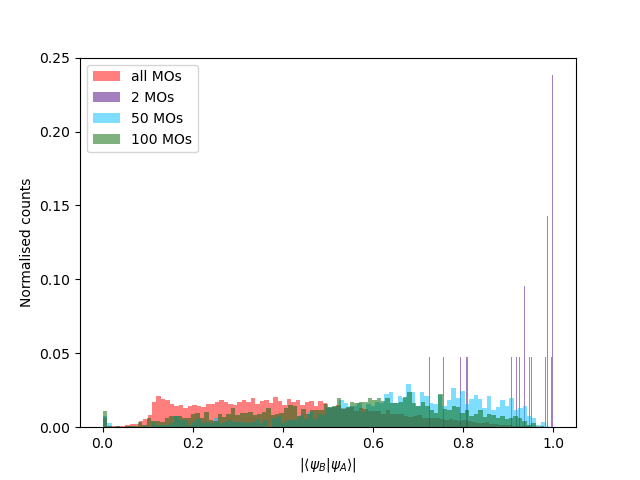

In [57]:
from qcnico.plt_utils import histogram

fig, ax = plt.subplots()

histogram(all_dots[(all_dots>=0)], xlabel=r'$|\langle\psi_B|\psi_A\rangle|$', plt_objs=(fig, ax), plt_kwargs={'color':'r', 'alpha':0.5, 'label':'all MOs'}, show=False,normalised=True)
histogram(all_dots2[(all_dots2>=0)], xlabel=r'$|\langle\psi_B|\psi_A\rangle|$', plt_objs=(fig, ax), plt_kwargs={'color':'indigo', 'alpha':0.5, 'label':'2 MOs'}, show=False,normalised=True)
histogram(all_dots50[(all_dots50>=0)], xlabel=r'$|\langle\psi_B|\psi_A\rangle|$', plt_objs=(fig, ax), plt_kwargs={'color':'deepskyblue', 'alpha':0.5, 'label':'50 MOs'}, show=False,normalised=True)
histogram(all_dots100[(all_dots100>=0)], xlabel=r'$|\langle\psi_B|\psi_A\rangle|$', plt_objs=(fig, ax), plt_kwargs={'color':'darkgreen', 'alpha':0.5, 'label':'100 MOs'}, show=False,normalised=True)
plt.legend()
plt.show()

[plt_utils.histogram] dx = 1.508000000205456e-08


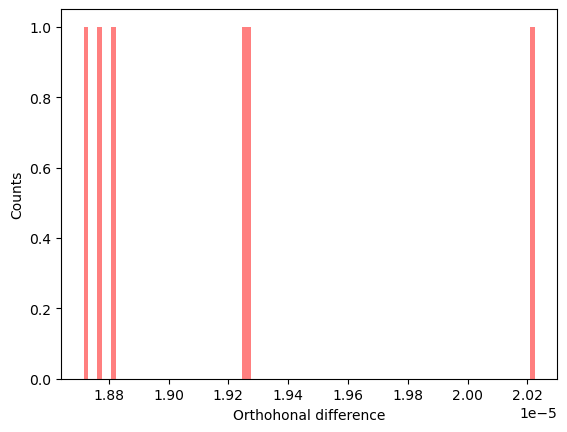

In [28]:
fig, ax = plt.subplots()
histogram(qorth_diff, xlabel='Orthohonal difference',plt_objs=(fig,ax), plt_kwargs={'alpha':0.5,'color':'r','label':'qcffpi'},show=False)
# histogram(borth_diff, xlabel='Orthohonal difference',plt_objs=(fig,ax), plt_kwargs={'alpha':0.5,'color':'b','label':'boys'},show=False)
plt.show()

[plt_utils.histogram] dx = 0.002435381184490608


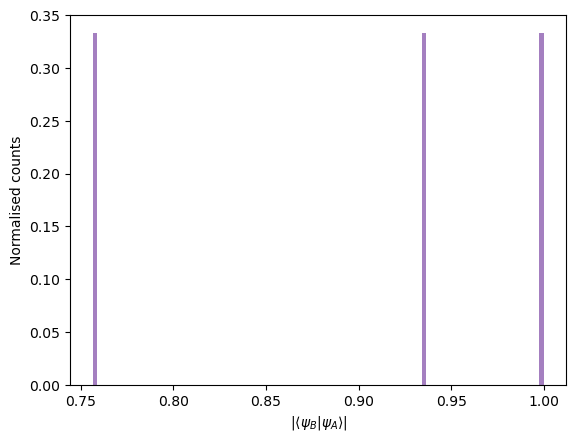

In [47]:
fig, ax = plt.subplots()
histogram(all_dots2[(all_dots2>=0)], xlabel=r'$|\langle\psi_B|\psi_A\rangle|$', plt_objs=(fig, ax), plt_kwargs={'color':'indigo', 'alpha':0.5, 'label':'2 MOs'}, show=False,normalised=True)
plt.show()

# Comparison of Arpack MOs and QCFFPI of 10nm $\times$ 10nm MAC

[[   5    6    7   10   14   18   19   23   24   27   28   31   32   33
    34   35   36   38   42   49   53   56   59   62   63   64   66   67
    70   72   76   77   78   81   82   83   84   85   88   89   90   92
    93   94   95   97  100  110  112  113  115  117  118  119  122  124
   128  129  130  131  132  133  135  137  138  139  142  143  145  147
   148  151  153  157  159  162  163  164  165  170  171  172  173  175
   178  179  180  182  188  190  191  192  193  194  195  197  198  199
   200  201  202  203  204  205  209  213  216  221  223  224  228  229
   230  231  233  237  238  240  243  245  248  252  254  255  257  258
   260  261  262  263  264  266  267  268  269  272  273  275  276  279
   280  284  285  288  289  290  291  293  295  296  298  299  300]
 [3588 3578 3564 3582 3536 3570 3554 3578 3538 3584 3600 3600 3592 3596
  3614 3596 3564 3572 3562 3602 3560 3594 3596 3562 3582 3582 3578 3586
  3550 3596 3540 3586 3578 3590 3578 3544 3554 3532 3610 3604 3594 3

/var/folders/gt/qhbvbx5d1hv7mm6w7y4738c40000gn/T/ipykernel_3213/3285832789.py:26: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  qcffpi_energies = np.hstack(get_shifted_eqcffpi(orbdir, lbls, natoms))


[plt_utils.histogram] dx = 0.14460734978116002


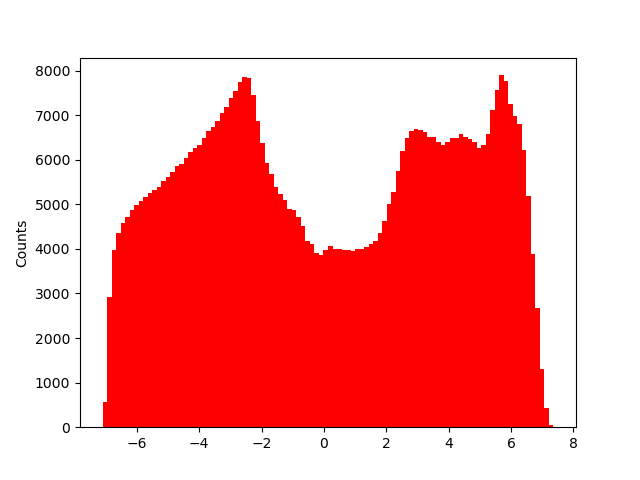

In [7]:
from qcnico.qcffpi_io import read_energies
from qcnico.plt_utils import histogram

def get_shifted_eqcffpi(orbdir,lbls, natoms):
    for n, N in zip(lbls, natoms):
        energies = read_energies(orbdir + f'orb_energy_pCNN_10x10-{n}.dat', Natoms=N)
        # N = energies.shape[0]
        eF = (energies[(N//2) -1] + energies[N//2]) * 0.5
        energies -= eF

        yield energies


with open('/Users/nico/Desktop/simulation_outputs/qcffpi_data/natoms.txt') as fo:
    fo.readline()
    fo.readline()
    lbls_natoms = np.array([list(map(int, l.strip().split())) for l in fo.readlines()]).T
    print(lbls_natoms)
    lbls, natoms = lbls_natoms


orbdir = '/Users/nico/Desktop/simulation_outputs/qcffpi_data/orbital_energies/10x10_pCNN_MAC_ensemble_TB/'
orbfiles = glob(orbdir + 'orb*dat')
qcffpi_lbls = np.sort([int(orbf.split('-')[1].split('.')[0]) for orbf in orbfiles])

qcffpi_energies = np.hstack(get_shifted_eqcffpi(orbdir, lbls, natoms))

histogram(qcffpi_energies)